# Seal Detection Model

## Setup
### Load Model

In [1]:
%matplotlib inline
%load_ext tensorboard

import torch
import os
from libs.tools.image import cv
from Models.Seals.checkpoint import load_model
from Models.Seals.evaluate import evaluate_image, eval_test
from Models.Seals.detection.evaluate import mAP_classes
from Models.Seals.detection import display, detection_table, box
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from libs.tools import struct, transpose_structs
import random
from collections import namedtuple

import Models.Seals.evaluate
from Models.Seals.dataset.imports import load_dataset
from torch.utils.data.dataloader import DataLoader

import datetime as dt
import numpy as np
import csv

#out_dir = "/csse/research/antarctica_seals/models/seal_od/Seals_2021-22"
out_dir = "/csse/users/jte52/Documents/Seals/models"
#out_dir = "/Models/Seals/log/Seals_2021-22_t"
model, encoder, args = load_model(f"{out_dir}/model.pth")
device = torch.cuda.current_device()
model = model.to(device)
encoder = encoder.to(device)
classes = args.dataset.classes

AttributeError: Can't get attribute 'Struct' on <module 'tools' from '/csse/users/jte52/miniconda3/envs/seal_env/lib/python3.8/site-packages/tools/__init__.py'>

### Helper Functions

In [ ]:
def is_responsible_bbox(bbox, frame=None):
    x1, y1, x2, y2 = bbox
    h, w = abs(y2 - y1), abs(x2 - x1)
    # Area > 1000px
    area = h * w
    if area > 1000:
        return False
    # Point outside of frame
    if frame != None:
        if x1 < 0 or x2 > frame.shape[1] or y1 < 0 or y2 > frame.shape[0]:
            return False
    ratio = 5
    if (w / h) > ratio or (h / w) > ratio:
        return False
    return True


def show(path, threshold=0.5):
    frame = cv.imread_color(path)
    h, w = frame.shape[:2]
    nms_params = detection_table.nms_defaults._extend(threshold = threshold)
    results = evaluate_image(model, frame, encoder, nms_params = nms_params, device=device)

    d, p = results.detections, results.prediction
    # box.clamp(d.bbox, (0, 0), (h, w))
    detections = list(zip(d.label, d.bbox, d.confidence))

    seal_count = 0
    for label, bbox, confidence in detections:
        if is_responsible_bbox(bbox, frame):
            label_class = classes[label]
            seal_count += 1 if label_class.name == "seal" else 2
            display.draw_box(frame, bbox, confidence=confidence, scale=1.0,
                name=label_class.name, color=display.to_rgb(label_class.colour), thickness=1)
#         else:
#             display.draw_box(frame, bbox, scale=1.0)
    print(seal_count, "seals detected")

    scale = 7
    plt.figure(figsize = (w/h*scale, scale))
    plt.imshow(frame, interpolation='nearest')
    plt.show()

## Demonstration

### 2019-20

In [ ]:
#scott_base_2019 = "/home/jte52/SENG402/data/images/scott_base/2019-20/"
scott_base_2019 = "/csse/research/antarctica_seals/images/scott_base/2019-20/"
camera = random.choice(os.listdir(scott_base_2019))
image = random.choice(os.listdir(scott_base_2019 + camera))
path = os.path.join(scott_base_2019, camera, image)
print(f'Camera: {camera}\nImage: {image}')
show(path)

Camera: CameraB
Image: C2659.jpg


NameError: name 'model' is not defined

### 2021-22

In [ ]:
#scott_base_2021 = "/home/jte52/2021-22/"
scott_base_2021 = "/csse/research/antarctica_seals/images/scott_base/2021-22/"
image = random.choice(os.listdir(scott_base_2021))
path = os.path.join(scott_base_2021, image)
print(f'Image: {image}')
show(path, 0.4)

Image: 2022-01-19T12_33_43.jpg


NameError: name 'model' is not defined

### Seal Day (332 Seals)

In [ ]:
#show('/home/jte52/SENG402/data/images/scott_base/2021-22/2022-01-23T13_33_48.jpg', 0.3)
show('/csse/research/antarctica_seals/images/scott_base/2021-22/2022-01-23T13_33_48.jpg', 0.3)

NameError: name 'model' is not defined

## Evaluate Model

### Load Test Dataset
Randomly select 10 images to test model on

In [ ]:
#scott_base_2021 = "/home/jte52/2021-22/"
scott_base_2021 = "/csse/research/antarctica_seals/images/scott_base/2021-22/"
for i in range(10):
    image = random.choice(os.listdir(scott_base_2021))
    path = os.path.join(scott_base_2021, image)
    print(f'Image: {image}')
    show(path, 0.5)

Image: 2021-12-23T05_18_08.jpg


NameError: name 'model' is not defined

### Record results

In [ ]:
TestResult = namedtuple('TestResult', 'img TP FP FN')
test_results = [
    TestResult("2022-01-04T15_33_26.jpg", 31, 1, 5),
    TestResult("2021-12-07T21_17_44.jpg", 12, 2, 7),
    TestResult("2022-01-02T13_48_23.jpg", 14, 0, 18),
    TestResult("2022-02-07T06_49_04.jpg", 59, 0, 14),
    TestResult("2021-12-01T06_17_36.jpg", 26, 0, 0),
    TestResult("2021-12-04T09_17_41.jpg", 22, 0, 1),
    TestResult("2021-12-07T04_17_44.jpg", 14, 0, 1),
    TestResult("2022-01-05T04_03_27.jpg", 11, 0, 2),
    TestResult("2022-01-19T18_48_43.jpg", 0, 0, 0),
    TestResult("2021-12-03T00_47_39.jpg", 11, 0, 8),    
]

### Calculate metrics

In [ ]:
total_TP = total_FP = total_FN = 0
for tr in test_results:
    total_TP += tr.TP
    total_FP += tr.FP
    total_FN += tr.FN
precision = total_TP / (total_TP + total_FP)
recall = total_TP / (total_TP + total_FN)
f1 = (2 * precision * recall) / (precision + recall)
accuracy = total_TP / (total_TP + total_FN + total_FP)

print(f"precision: {precision}, recall: {recall}, f1: {f1}, accuracy: {accuracy}")

precision: 0.9852216748768473, recall: 0.78125, f1: 0.8714596949891067, accuracy: 0.7722007722007722


## Analyse

### Load Seal Counts from CSV

In [ ]:
datetimes = []
counts_30 = []
counts_40 = []
counts_50 = []
snowstorms = []
snowstorm_confidences = []

with open('data/counts/scott_base-21-22-s.csv', 'r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    next(lines)
    for row in lines:
        datetimes.append(dt.datetime.strptime(row[0], "%Y-%m-%dT%H_%M_%S"))
        counts_30.append(int(row[1]))
        counts_40.append(int(row[2]))
        counts_50.append(int(row[3]))
        snowstorms.append(row[4] == "Yes")
        snowstorm_confidences.append(float(row[5]))

### Displays counts over season

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


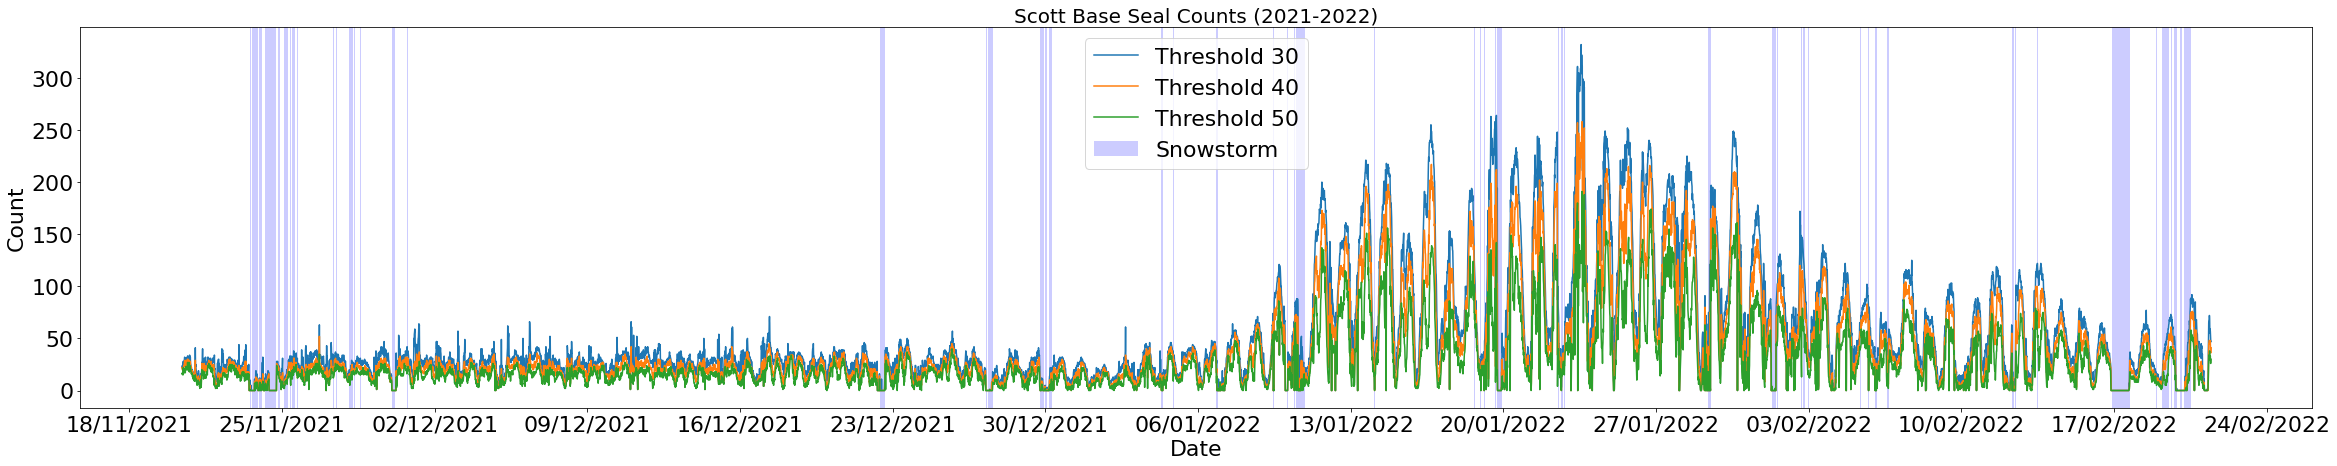

In [ ]:
_datetimes = datetimes

f = plt.figure()
f.set_figwidth(40) 
f.set_figheight(7)

font = {'family' : 'arial',
        'size'   : 22}
plt.rc('font', **font)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Scott Base Seal Counts (2021-2022)', fontsize=20)


plt.plot(_datetimes, counts_30, label='Threshold 30', color='tab:blue')
plt.plot(_datetimes, counts_40, label='Threshold 40', color='tab:orange')
plt.plot(_datetimes, counts_50, label='Threshold 50', color='tab:green')

plt.legend()
for i in range(len(snowstorms)):
    snowstorm, confidence = snowstorms[i], snowstorm_confidences[i]
    if snowstorm and confidence > 90 and i != len(snowstorms) - 1:
        plt.axvspan(_datetimes[i], _datetimes[i+1], facecolor='b', alpha=0.2, label='Snowstorm')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))


### Try to model counts over season
#### Calculate Fouirer Transform
Calculate the Fourier Transform of the counts to isolate the frequency of the haulouts.

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


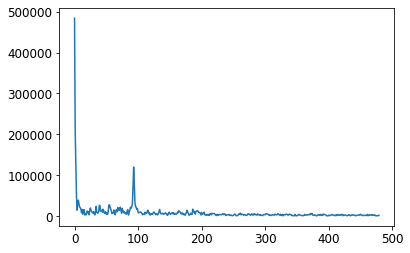

Top 5 frequencies:
Frequency: 0.00
Period: inf days

Frequency: 95.00
Period: 0.011 days

Frequency: 1.00
Period: 1.000 days

Frequency: 94.99
Period: 0.011 days

Frequency: 1.01
Period: 0.989 days

Frequency: 0.03
Period: 30.990 days

Frequency: 95.97
Period: 0.010 days

Frequency: 0.08
Period: 13.281 days

Frequency: 95.92
Period: 0.010 days

Frequency: 1.03
Period: 0.968 days

Frequency: 94.97
Period: 0.011 days

Frequency: 95.63
Period: 0.010 days

Frequency: 0.37
Period: 2.734 days

Frequency: 0.42
Period: 2.384 days

Frequency: 95.58
Period: 0.010 days

Frequency: 95.03
Period: 0.011 days

Frequency: 0.97
Period: 1.033 days

Frequency: 0.11
Period: 9.297 days

Frequency: 95.89
Period: 0.010 days

Frequency: 0.59
Period: 1.690 days

Frequency: 95.41
Period: 0.010 days

Frequency: 0.15
Period: 6.641 days

Frequency: 95.85
Period: 0.010 days

Frequency: 0.13
Period: 7.747 days

Frequency: 95.87
Period: 0.010 days

Frequency: 95.21
Period: 0.011 days

Frequency: 0.79
Period: 1.274 da

/tmp/ipykernel_29343/3964066969.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  p = 1 / f_per_day


In [ ]:
font = {'family' : 'arial',
        'size'   : 12}
plt.rc('font', **font)

counts = counts_30
T = 15  # Images taken every 15 minutes
fft = np.fft.fft(counts)
# Clip the zero frequency and frequencies above 2 days
two_day_f = (5 * 24 * 60) / T
# fft[0] = 0
# fft[int(two_day_f):] = 0
plt.plot(np.abs(fft)[:int(two_day_f)])
plt.show()

top_5 = np.argsort(fft)[::-1][:100]
print("Top 5 frequencies:")
for f in top_5:
    f_per_image = f / len(counts)
    f_per_day = f_per_image * (24 * 60) / T
    print(f"Frequency: {f_per_day:.2f}")
    p = 1 / f_per_day
    print(f"Period: {p:.3f} days\n")


#### Set non-dominant frequencies to zero & Take inverse Fourier Transform

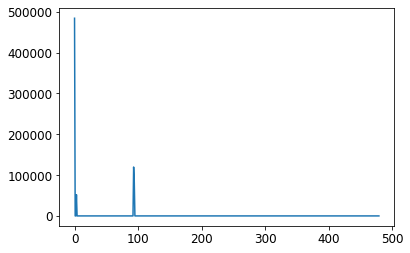

/csse/users/jte52/miniconda3/envs/seal_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


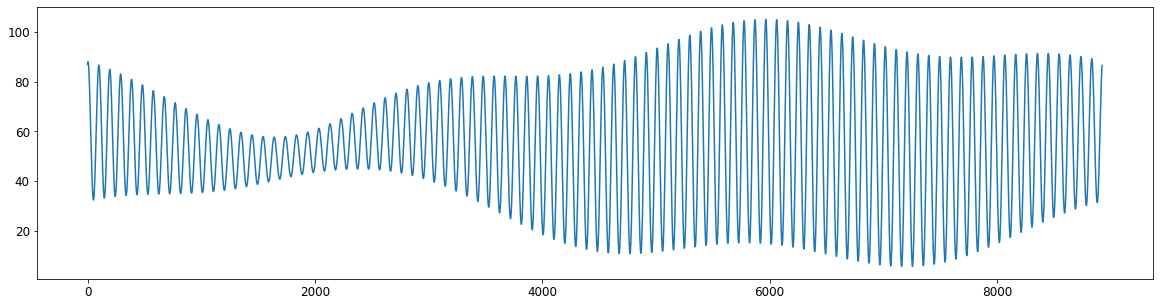

In [ ]:
_fft = fft.copy()
# Set non-top frequencies to zero
for i in range(len(_fft)):
    if i not in top_5[:6]:
        _fft[i] = 0
plt.plot(np.abs(_fft)[:int(two_day_f)])
plt.show()

# Inverse FFT
f = plt.figure() 
f.set_figheight(5)
f.set_figwidth(20)
ifft = np.fft.ifft(_fft)
plt.plot(ifft)
plt.show()


### Graph Training Data
Graph the data collected while training the model. This data has been taken from the Tensorboard logs.
#### Load Training Data from CSV

In [ ]:
times = []
steps = []
total_losses = []
loc_losses = []
class_losses = []
bal_class_losses = []
aps = []
mAP30s = []
mAP50s = []
mAP75s = []

with open('data/training_stats.csv', 'r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    next(lines)
    for time, step, total_loss, loc_loss, class_loss, bal_class_loss, ap, mAP30, mAP50, mAP75 in lines:
        times.append(int(time))
        steps.append(int(step))
        total_losses.append(float(total_loss))
        loc_losses.append(float(loc_loss))
        class_losses.append(float(class_loss))
        bal_class_losses.append(float(bal_class_loss))
        aps.append(float(ap))
        mAP30s.append(float(mAP30))
        mAP50s.append(float(mAP50))
        mAP75s.append(float(mAP75))

#### Graph loaded data

In [ ]:
font = {'family' : 'arial',
        'size'   : 12}
plt.rc('font', **font)
min_loss_epoch = np.argmin(total_losses) + 1
print(f"Minimum total loss at epoch {min_loss_epoch}")

Minimum total loss at epoch 40


##### Focal Loss

Chosen Model Total Loss: 0.329, Location Loss: 0.256, Classification Loss: 0.295


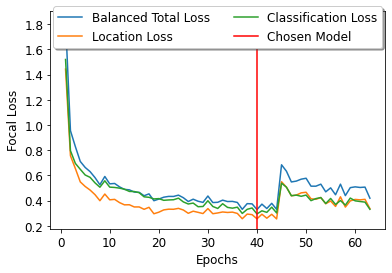

In [ ]:
plt.ylabel('Focal Loss')
plt.xlabel('Epochs')
plt.plot(steps, total_losses, label='Balanced Total Loss')
plt.plot(steps, loc_losses, label='Location Loss')
plt.plot(steps, class_losses, label='Classification Loss')
plt.axvline(x = min_loss_epoch, color = 'r', label = 'Chosen Model')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2, fancybox=True, shadow=True)
print(f"Chosen Model Total Loss: {total_losses[min_loss_epoch-1]:.3f}, Location Loss: {loc_losses[min_loss_epoch-1]:.3f}, Classification Loss: {class_losses[min_loss_epoch-1]:.3f}")

##### Average Precision

Chosen Model AP: 21.119, mAP@30: 37.611, mAP@50: 37.609, mAP@75: 23.172


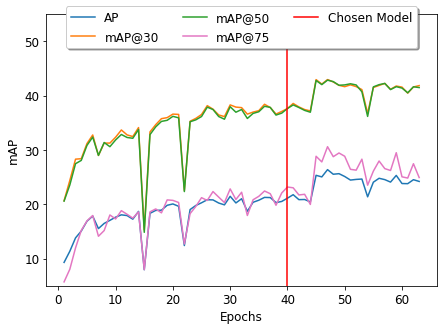

In [ ]:
f = plt.figure() 
f.set_figheight(5)
f.set_figwidth(7)
ax = plt.gca()
ax.set_ylim([5, 55])
plt.ylabel('mAP')
plt.xlabel('Epochs')
plt.plot(steps, aps, label='AP')
plt.plot(steps, mAP30s, label='mAP@30')
plt.plot(steps, mAP50s, label='mAP@50')
plt.plot(steps, mAP75s, label='mAP@75', color='tab:pink')
plt.axvline(x = min_loss_epoch, color = 'r', label = 'Chosen Model')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
print(f"Chosen Model AP: {aps[min_loss_epoch-1]:.3f}, mAP@30: {mAP30s[min_loss_epoch-1]:.3f}, mAP@50: {mAP50s[min_loss_epoch-1]:.3f}, mAP@75: {mAP75s[min_loss_epoch-1]:.3f}")